In [104]:
import boto3 
from boto3.session import Session 
import pandas as pd 
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from collections import Counter

import pandas as pd
import numpy as np
import re  
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
import configparser
Config = configparser.ConfigParser()
Config.read_file(open('/Users/milesklingenberg/Documents/Personal/AWS_Keys'))

In [3]:
KEY = Config.get('AWS', 'AWS_ACCESS_KEY_ID')
SECRET = Config.get('AWS', 'Secret')

In [4]:
#we are storing the data on AWS. 

s3 = boto3.resource('s3',
                       region_name="us-west-2",
                       aws_access_key_id=KEY,
                       aws_secret_access_key=SECRET
                   )
s3client = boto3.client('s3', 
                       aws_access_key_id=KEY,
                       aws_secret_access_key=SECRET)

In [5]:
#Just a list to look at my available buckets for naming conventions. 
#for bucket in s3.buckets.all():
    #print(bucket.name)

In [6]:
file = s3client.get_object(Bucket = 'lyrics-for-570', Key = 'lyrics.csv')

#If you want to read this yourself just replace the pr.read_csv to the local path for your data, otherwise 
#this s3 bucket is public. 

In [7]:
lyrics = pd.read_csv(file['Body'])
lyrics = pd.DataFrame(lyrics)

In [8]:
#Want to look at the structure of our data set. 
print(lyrics.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362237 entries, 0 to 362236
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   index   362237 non-null  int64 
 1   song    362235 non-null  object
 2   year    362237 non-null  int64 
 3   artist  362237 non-null  object
 4   genre   362237 non-null  object
 5   lyrics  266557 non-null  object
dtypes: int64(2), object(4)
memory usage: 16.6+ MB
None


In [9]:
#We will probably need to run this on a virtual server in order to do ETL and 
#modeling for 

#When we are ready to deploy this model we will want to remove this portion and 
#extend efforts to whole data set. 

lyrics = lyrics[0:10000]

In [10]:
#switching variables here as it takes awhile to load in the data each time. 
lyrics_1 = lyrics
#We can also take a peak at the data 

In [11]:
#typically we could sub values where there are Null, but for lyrics this is obviously not possible, so we 
#will remove 

In [12]:
#We know that the length of our data is 30k 
#lyrics_1 = lyrics_1.dropna()

#You could label based on the artist and the propensity for offensiveness. 
#Something that was annoying is that the csv actually had "nan" as an entry as opposed 
#to actually nan value. 

In [13]:
#This function does all of the preprocessing steps for us. 

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(data):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)


lyrics_1['lyrics_cleaned_total']=lyrics_1['lyrics'].map(lambda s:preprocess(s)) 

##lambda exampe.  lyrics['test']= lyrics['lyrics'].apply(lambda x: 1 if len(x) > 1)

In [14]:
#lyrics_1.drop(lyrics_1.columns[len(lyrics_1.columns)-1], axis=1, inplace=True)

In [15]:
lyrics_1

,index,song,year,artist,genre,lyrics,lyrics_cleaned_total
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu...",baby know gonna cut right chase women made lik...
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see...",playin everything easy like seem sure still wa...
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...,search tenderness hard find love need live loo...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...",verse wrote book stand title book would life s...
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po...",party people people party popping sitting arou...
...,...,...,...,...,...,...,...
9995,9995,tu-es-a-unica,1999,berg,Other,NaN,nan
9996,9996,medo-de-amor,1999,berg,Other,NaN,nan
9997,9997,perto-de-ti,1999,berg,Other,NaN,nan
9998,9998,dizes-nda-o,1999,berg,Other,NaN,nan


In [16]:
l = [' '.join(lyrics_1['lyrics_cleaned_total'])]

In [17]:
def word_count(obj): 
    frequencies = pd.DataFrame()
    obj = str(obj)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(obj)
    counts = Counter(tokens)
    frame = frequencies.append(
         counts.most_common(n=100),
         counts)
    return frame

total_df = word_count(l)
total_df.columns = ['word', 'count']
total_df.sort_values('count', ascending=False)
top_word_count = total_df.head(30)

In [18]:
total_df.head(5)

,word,count
0,like,8389
1,know,8229
2,love,7560
3,get,6600
4,got,5883


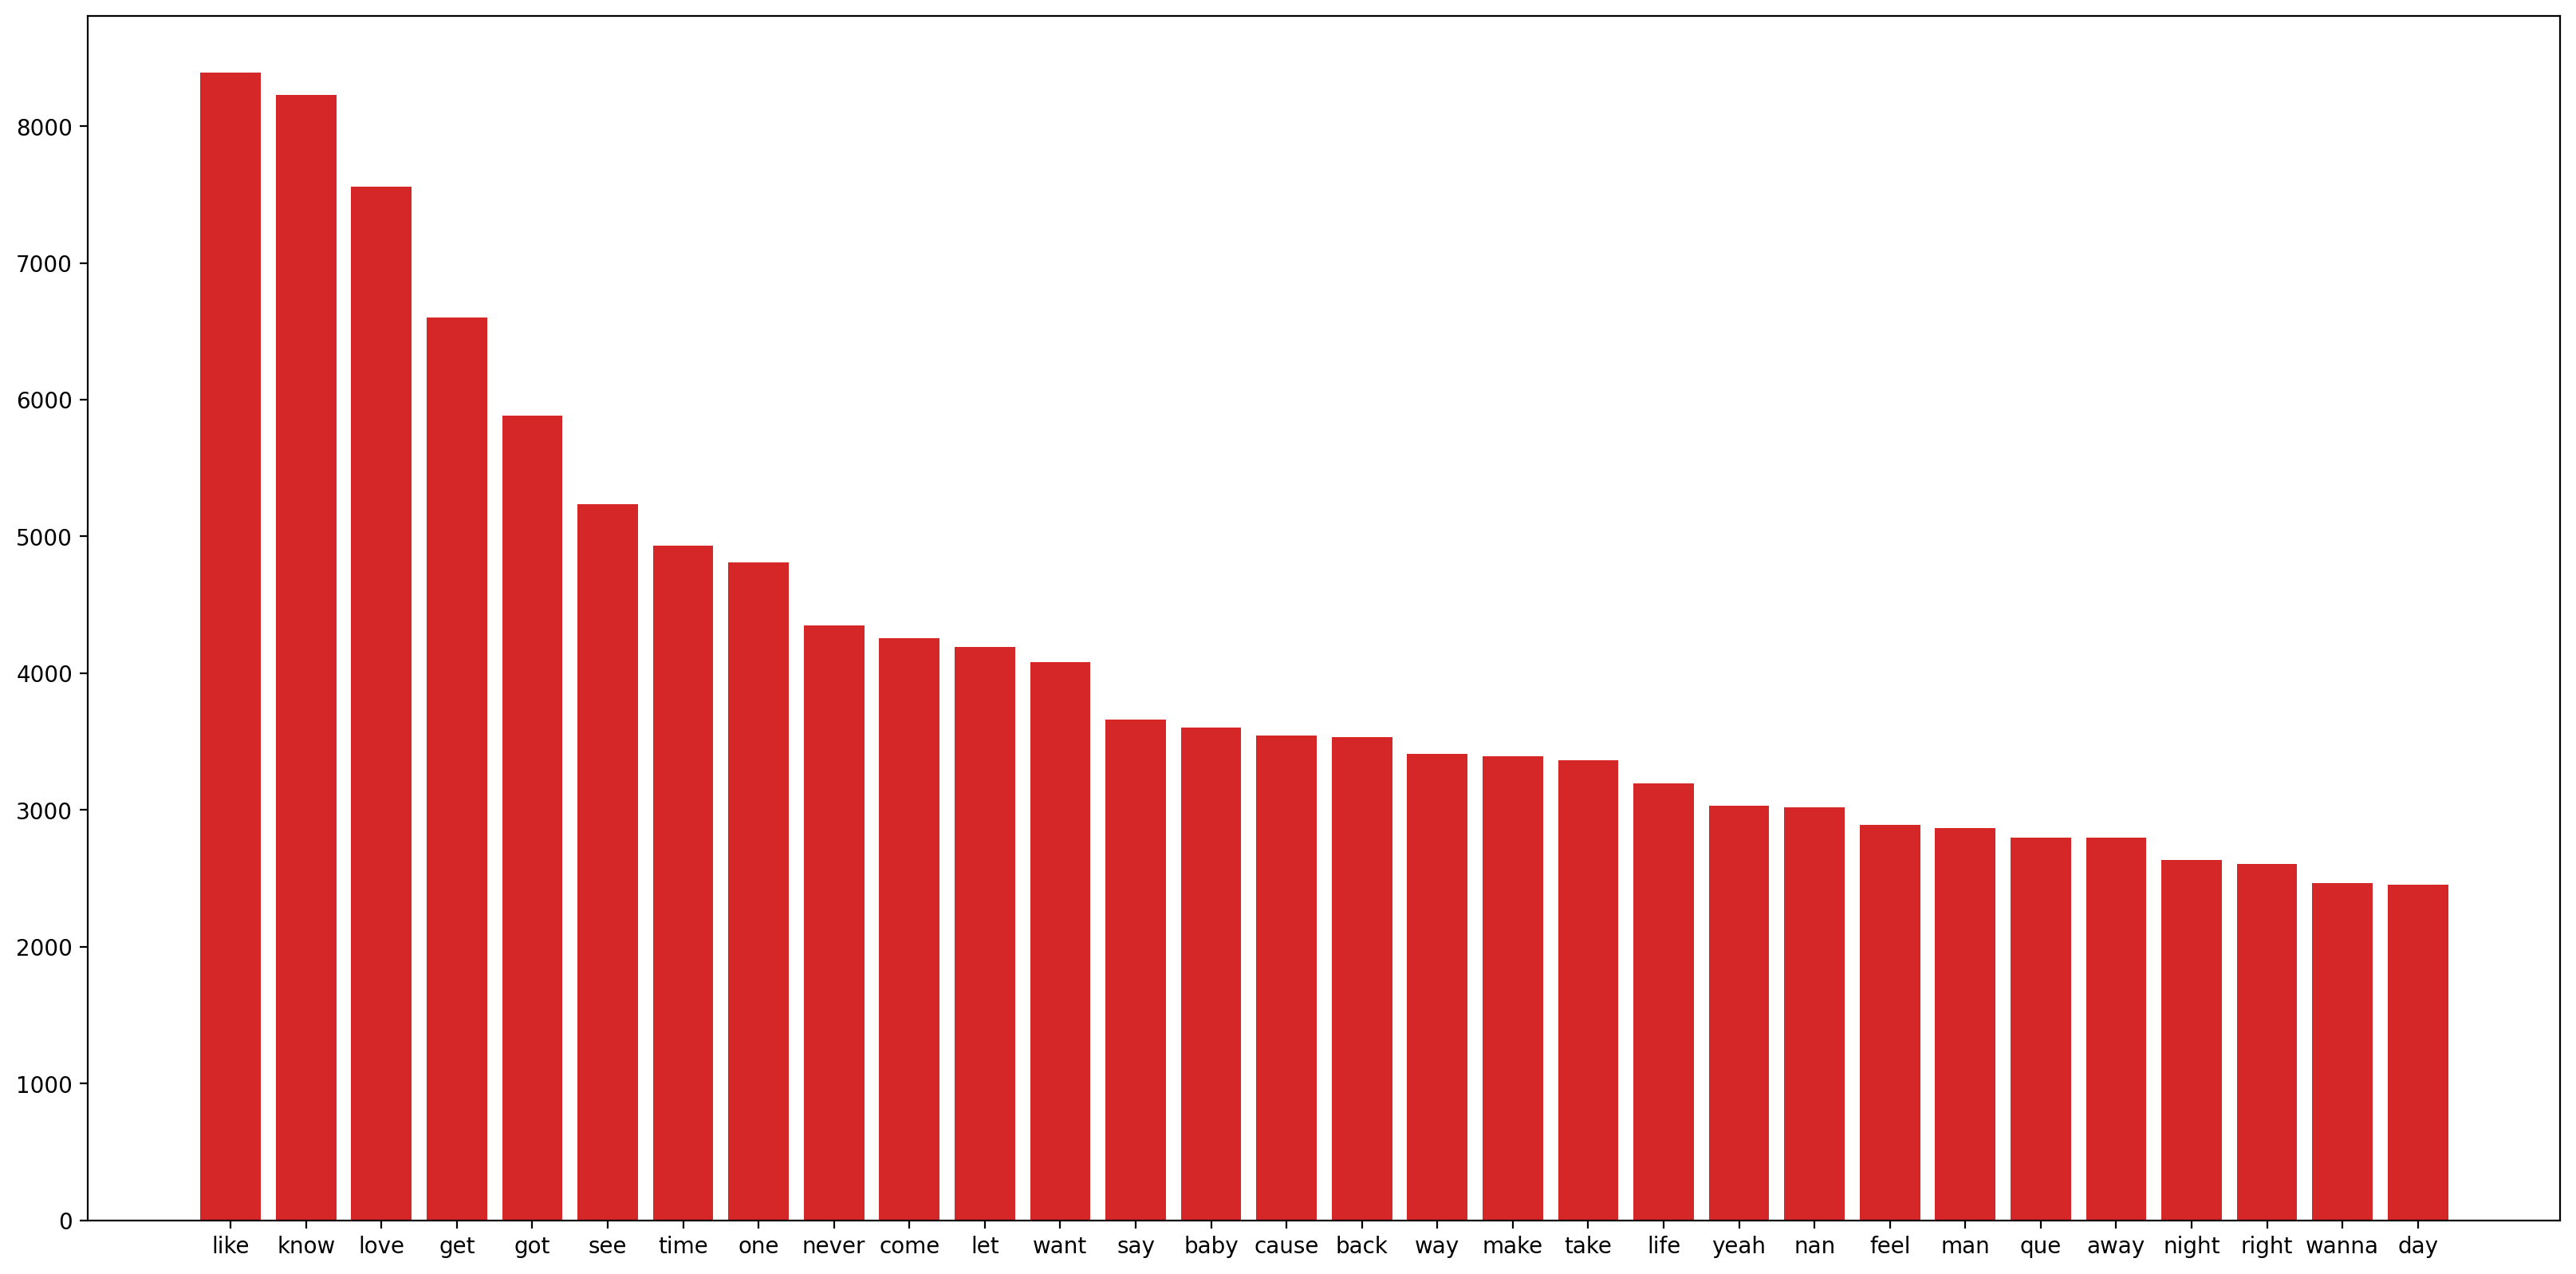

In [19]:
plt.figure(figsize=(20,10), dpi=200)
color = 'tab:red'
plt.bar(top_word_count['word'], top_word_count['count'],color=color)

plt.show()

#This plot shows us the most used words. 

In [21]:
word_counts = []
unique_word_counts = []
for i in range (0, len(lyrics_1)):
    word_counts.append(len(lyrics_1.iloc[i]['lyrics_cleaned_total'].split()))
    unique_word_counts.append(len(set(lyrics_1.iloc[i]['lyrics_cleaned_total'].split())))
lyrics_1['Word Counts'] = word_counts
lyrics_1['Unique Words'] = unique_word_counts

In [23]:
lyrics_1.head(5)
#Just checking to make sure that the two columns were appended correctly. 

,index,song,year,artist,genre,lyrics,lyrics_cleaned_total,word_count_total,Word Counts,Unique Words
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu...",baby know gonna cut right chase women made lik...,182,182,85
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see...",playin everything easy like seem sure still wa...,115,115,70
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...,search tenderness hard find love need live loo...,73,73,58
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote...",verse wrote book stand title book would life s...,190,190,73
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po...",party people people party popping sitting arou...,151,151,23


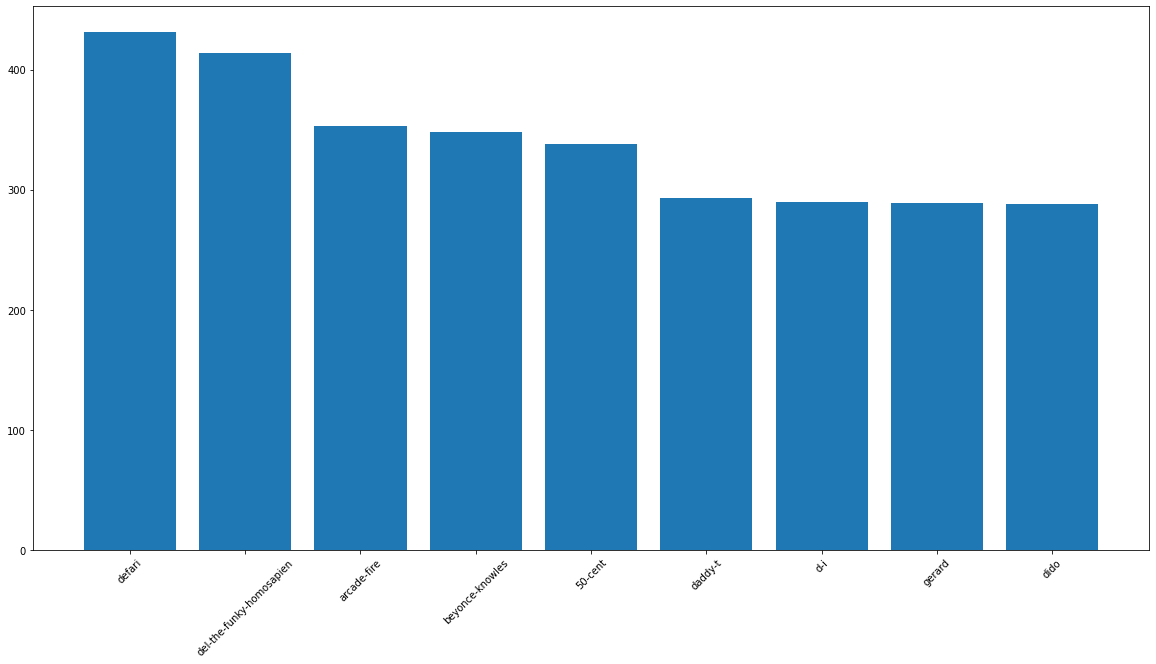

In [24]:
artist_table = lyrics_1.sort_values('Unique Words', ascending = False)
artist_table = artist_table.head(30)
plt.figure(figsize = (20,10))

plt.bar(artist_table['artist'], artist_table['Unique Words'].values)
plt.xticks(rotation = 45)
plt.show()

#Here we can see the total number of unique word used by the artists with the most unique words. 

In [71]:
summary_dataset = pd.DataFrame()
years = lyrics_1['year'].unique().tolist()
for i in range(0, len(years)):
    row = {
        "Year": years[i],
        "Average Words": lyrics_1['Word Counts'][lyrics_1['year'] == years[i]].mean(),
        "Unique Words": lyrics_1['Unique Words'][lyrics_1['year'] == years[i]].mean()
    }
    summary_dataset = summary_dataset.append(row, ignore_index=True)
summary_dataset["Year"] = summary_dataset['Year'].astype(int)

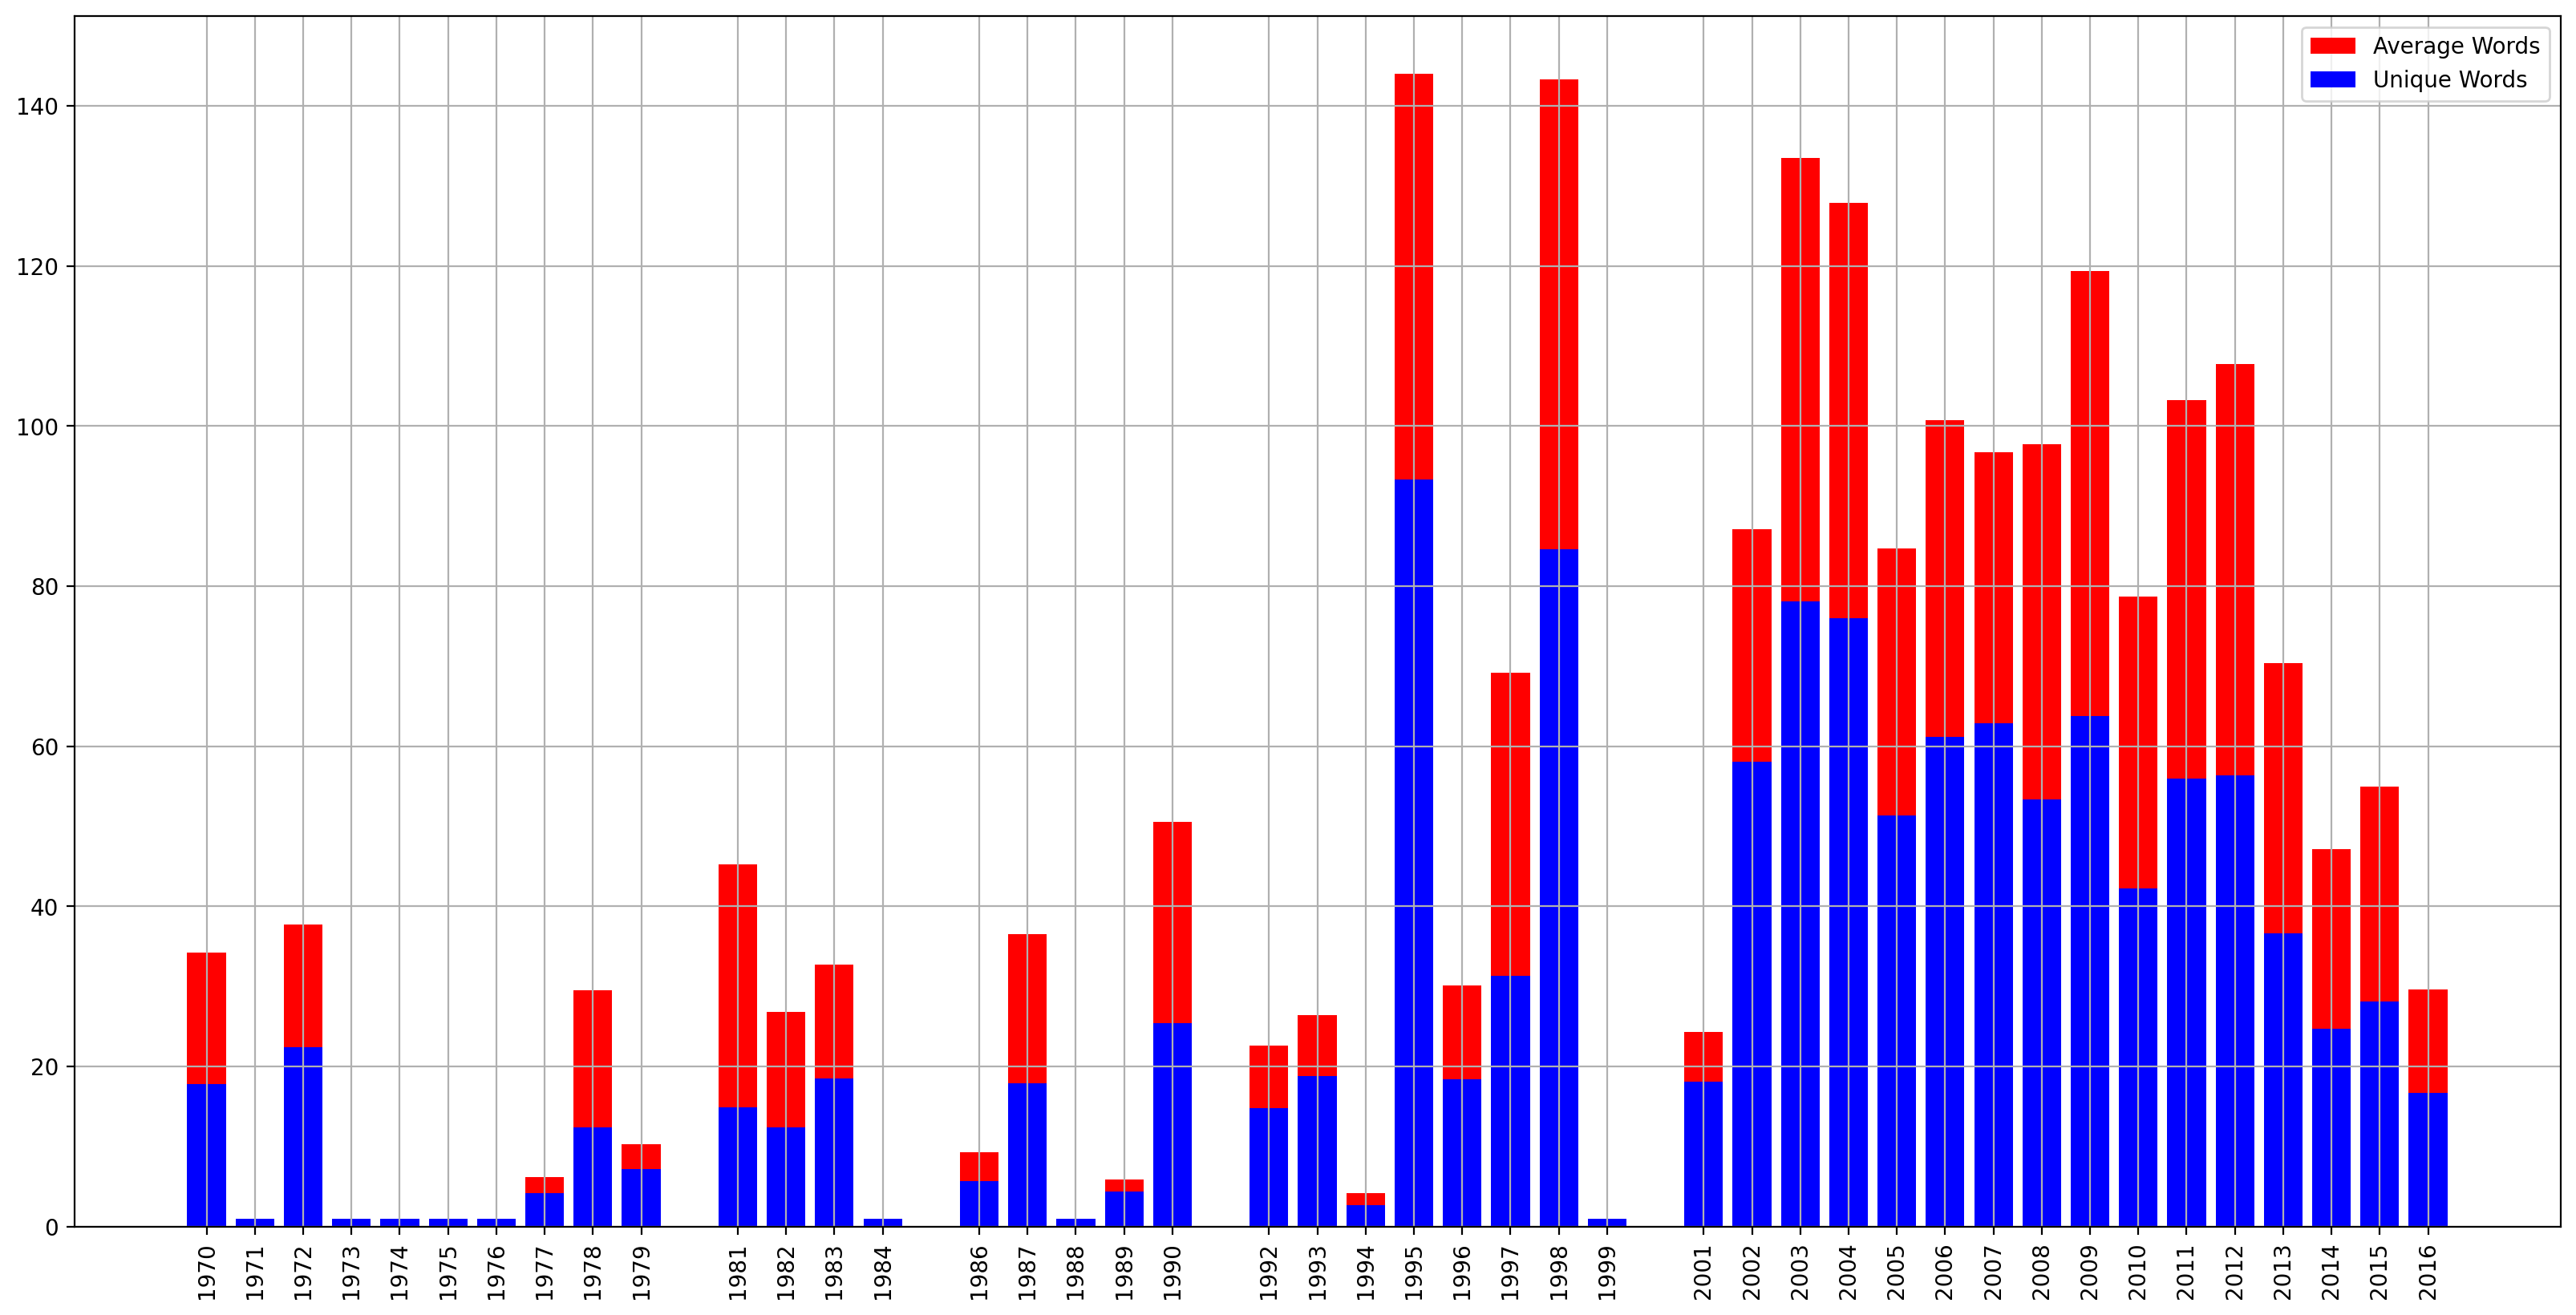

In [69]:
#Here we are looking at the average number of words per year
#We are also looking at the unique words per year

plt.figure(figsize=(20,10), dpi=200)
plt.bar(summary_dataset['Year'], summary_dataset['Average Words'].values, color="red", label="Average Words")
plt.bar(summary_dataset['Year'], summary_dataset['Unique Words'].values, color = "blue", label = "Unique Words")
plt.xticks(summary_dataset['Year'], rotation=90)
plt.grid()
plt.legend()
plt.show()

In [70]:
#Interestinly, you can see some unique patterns in the data. 

In [73]:
from better_profanity import profanity

In [91]:
lyrics_1['profanity'] = lyrics_1['lyrics_cleaned_total'].apply(lambda x: 1 if profanity.contains_profanity(x) else 0)

In [94]:
#With this last column we have successfully determined whether our lyrics have a swear word in
#them or not which we will explore further. 

In [ ]:
#nltk.download('averaged_perceptron_tagger')

In [229]:

from nltk import word_tokenize, pos_tag
tok_and_tag = lambda x: pos_tag(word_tokenize(x))
lyrics_1['letter_lyrics'] = re.sub("[^a-zA-Z]",  
                          " ",         
                          str(lyrics_1['lyrics_cleaned_total']))

tok_and_tag(lyrics_1['letter_lyrics'][0])

lyrics_1['types'] = lyrics_1['letter_lyrics'].apply(tok_and_tag)

In [230]:
lyrics_1

,index,song,year,artist,genre,lyrics,lyrics_cleaned_total,word_count_total,Word Counts,Unique Words,year_int,profanity,letter_lyrics,types
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cut right to the chase\nSome women were made but me,...","[baby, know, gon, na, cut, right, chase, women, made, like, think, created, special, purpose, kn...",182,182,85,2009.0,1,baby know gon na cut right chase women made like think created special pur...,"[(baby, NN), (know, VBP), (gon, VBG), (na, TO), (cut, VB), (right, JJ), (chase, NN), (women, NNS..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you seem so sure.\nstill your ways, you dont see\ni'm not...","[playin, everything, easy, like, seem, sure, still, ways, dont, see, sure, things, come, right, ...",115,115,70,2009.0,0,baby know gon na cut right chase women made like think created special pur...,"[(baby, NN), (know, VBP), (gon, VBG), (na, TO), (cut, VB), (right, JJ), (chase, NN), (women, NNS..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard to find\nYou can have the love\nYou need to live\nB...,"[search, tenderness, hard, find, love, need, live, look, truthfulness, might, well, blind, alway...",73,73,58,2009.0,0,baby know gon na cut right chase women made like think created special pur...,"[(baby, NN), (know, VBP), (gon, VBG), (na, TO), (cut, VB), (right, JJ), (chase, NN), (women, NNS..."
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote a book about where we stand\nThen the title of my...","[verse, wrote, book, stand, title, book, would, life, superman, make, feel, count, privilege, lo...",190,190,73,2009.0,0,baby know gon na cut right chase women made like think created special pur...,"[(baby, NN), (know, VBP), (gon, VBG), (na, TO), (cut, VB), (right, JJ), (chase, NN), (women, NNS..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's popping no sitting around,\nI see you looking you lo...","[party, people, people, party, popping, sitting, around, see, looking, looking, see, look, start...",151,151,23,2009.0,0,baby know gon na cut right chase women made like think created special pur...,"[(baby, NN), (know, VBP), (gon, VBG), (na, TO), (cut, VB), (right, JJ), (chase, NN), (women, NNS..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,tu-es-a-unica,1999,berg,Other,NaN,[nan],1,1,1,1999.0,0,baby know gon na cut right chase women made like think created special pur...,"[(baby, NN), (know, VBP), (gon, VBG), (na, TO), (cut, VB), (right, JJ), (chase, NN), (women, NNS..."
9996,9996,medo-de-amor,1999,berg,Other,NaN,[nan],1,1,1,1999.0,0,baby know gon na cut right chase women made like think created special pur...,"[(baby, NN), (know, VBP), (gon, VBG), (na, TO), (cut, VB), (right, JJ), (chase, NN), (women, NNS..."
9997,9997,perto-de-ti,1999,berg,Other,NaN,[nan],1,1,1,1999.0,0,baby know gon na cut right chase women made like think created special pur...,"[(baby, NN), (know, VBP), (gon, VBG), (na, TO), (cut, VB), (right, JJ), (chase, NN), (women, NNS..."
9998,9998,dizes-nda-o,1999,berg,Other,NaN,[nan],1,1,1,1999.0,0,baby know gon na cut right chase women made like think created special pur...,"[(baby, NN), (know, VBP), (gon, VBG), (na, TO), (cut, VB), (right, JJ), (chase, NN), (women, NNS..."


In [ ]:
#Small problem in the original tokenization, apparently there were still some non letters that
# I missed in the original function, I have removed those in the last function and passed the word types. 